In [21]:
# a. Import required libraries
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

In [22]:
# ------------------------------------------------------------
# b. Load and preprocess CIFAR-10 dataset
# ------------------------------------------------------------
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [23]:
# Normalize images (0–255 → 0–1)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [24]:
# One-hot encode labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [25]:
# ------------------------------------------------------------
# c. Load pre-trained CNN (VGG16 trained on ImageNet)
# ------------------------------------------------------------
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

In [26]:
# Freeze the lower convolutional layers
for layer in base_model.layers:
    layer.trainable = False

In [27]:
# ------------------------------------------------------------
# d. Add custom classifier layers
# ------------------------------------------------------------
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')  # CIFAR-10: 10 classes
])


In [28]:
# ------------------------------------------------------------
# e. Compile model (initial training of top classifier layers)
# ------------------------------------------------------------
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
# ------------------------------------------------------------
# f. Train the model (frozen convolutional base)
# ------------------------------------------------------------
history_1 = model.fit(x_train, y_train,
                      epochs=10,
                      batch_size=64,
                      validation_split=0.1,
                      verbose=1)

Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 55s 77ms/step - accuracy: 0.4764 - loss: 1.4752 - val_accuracy: 0.5712 - val_loss: 1.2222
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 64s 90ms/step - accuracy: 0.5462 - loss: 1.2860 - val_accuracy: 0.5870 - val_loss: 1.1740
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 67s 95ms/step - accuracy: 0.5696 - loss: 1.2215 - val_accuracy: 0.5998 - val_loss: 1.1388
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 111s 157ms/step - accuracy: 0.5826 - loss: 1.1914 - val_accuracy: 0.6068 - val_loss: 1.1313
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 157s 223ms/step - accuracy: 0.5910 - loss: 1.1629 - val_accuracy: 0.6124 - val_loss: 1.1023
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 156s 222ms/step - accuracy: 0.6006 - loss: 1.1345 - val_accuracy: 0.6162 - val_loss: 1.0924
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 157s 223ms/step - accuracy: 0.6083 - loss: 1.1097 - val_accuracy: 0.6168 - val_loss: 1.0934
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 154s 218ms/step - accuracy: 0.6143 - loss:

In [30]:
# ------------------------------------------------------------
# g. Evaluate after initial training
# ------------------------------------------------------------
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("\nBefore Fine-tuning:")
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)


Before Fine-tuning:
Test Loss: 1.1104313135147095
Test Accuracy: 0.6115000247955322


In [31]:
# ------------------------------------------------------------
# h. Fine-tune: Unfreeze deeper layers & lower learning rate
# ------------------------------------------------------------
# Unfreeze last 4 convolutional blocks for fine-tuning
for layer in base_model.layers[-8:]:
    layer.trainable = True

In [32]:
# Recompile with smaller learning rate (critical for fine-tuning)
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [34]:
# ------------------------------------------------------------
# i. Continue training (fine-tuning)
# ------------------------------------------------------------
history_2 = model.fit(x_train, y_train,
                      epochs=2,
                      batch_size=64,
                      validation_split=0.1,
                      verbose=1)

Epoch 1/2
704/704 ━━━━━━━━━━━━━━━━━━━━ 277s 394ms/step - accuracy: 0.7254 - loss: 0.7785 - val_accuracy: 0.7096 - val_loss: 0.8177
Epoch 2/2
704/704 ━━━━━━━━━━━━━━━━━━━━ 277s 393ms/step - accuracy: 0.7647 - loss: 0.6597 - val_accuracy: 0.7330 - val_loss: 0.7864


In [35]:
# ------------------------------------------------------------
# j. Evaluate after fine-tuning
# ------------------------------------------------------------
test_loss_ft, test_acc_ft = model.evaluate(x_test, y_test, verbose=0)
print("\nAfter Fine-tuning:")
print("Test Loss:", test_loss_ft)
print("Test Accuracy:", test_acc_ft) 


After Fine-tuning:
Test Loss: 0.8103047609329224
Test Accuracy: 0.7265999913215637


In [36]:
# ------------------------------------------------------------
# k. Plot training & validation accuracy/loss for both phases
# ------------------------------------------------------------
plt.figure(figsize=(14, 6))

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

In [37]:
# Combine histories
train_acc = history_1.history['accuracy'] + history_2.history['accuracy']
val_acc = history_1.history['val_accuracy'] + history_2.history['val_accuracy']
train_loss = history_1.history['loss'] + history_2.history['loss']
val_loss = history_1.history['val_loss'] + history_2.history['val_loss']

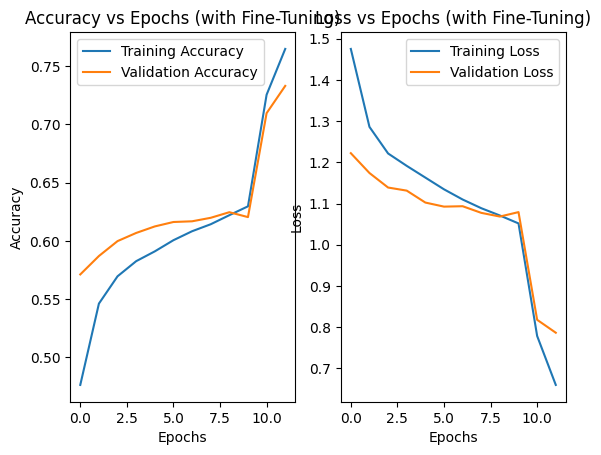

In [38]:
# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title("Accuracy vs Epochs (with Fine-Tuning)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title("Loss vs Epochs (with Fine-Tuning)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [39]:
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

In [40]:
# Predict on some test samples
predictions = model.predict(x_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 124ms/step


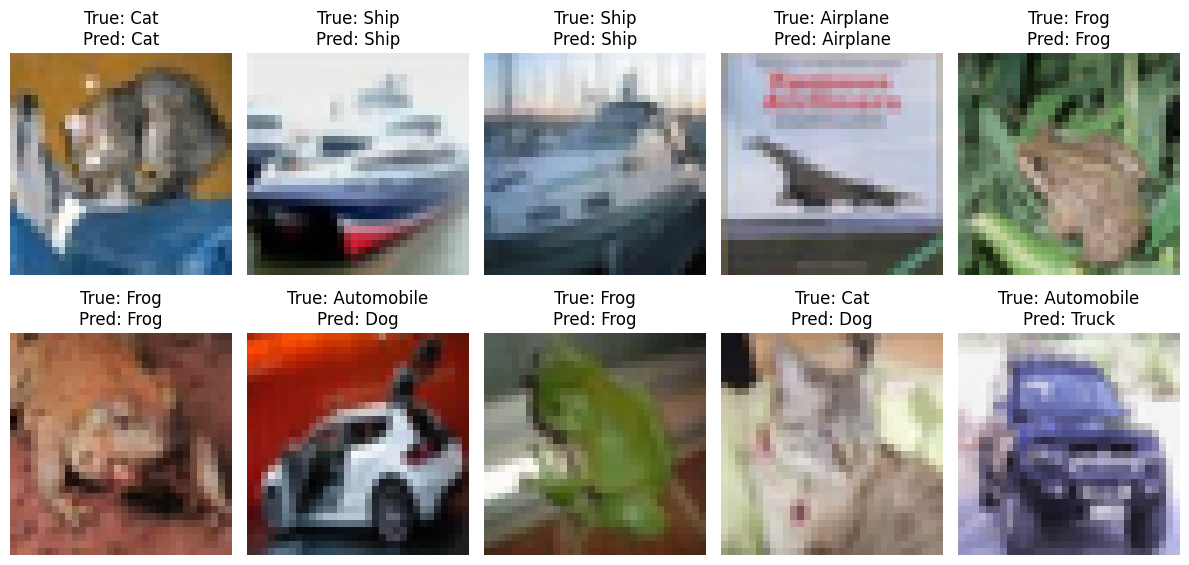

In [41]:
# Show 10 images with predictions
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[i])
    plt.title(f"True: {class_names[y_true[i]]}\nPred: {class_names[y_pred[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()